In [1]:
# import the necessary library

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import kaggle

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Download dataset directly from the Kaggle API

!kaggle datasets download -d jaganadhg/house-hold-energy-data

403 - Forbidden


In [3]:
# Name of the zip file
zipfile_name = 'house-hold-energy-data.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zipfile_name, 'r') as file:
    file.extractall()

print("Extraction completed!")

Extraction completed!


In [4]:
# read the extracted file

dfe = pd.read_csv('D202.csv')

dfe.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [5]:
# get a bit of information of the dataset

dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


In [6]:
# let's convert the DATE column into Datetime format

dfe['DATE'] = pd.to_datetime(dfe['DATE'], format = '%m/%d/%Y')

print(dfe.dtypes)

TYPE                  object
DATE          datetime64[ns]
START TIME            object
END TIME              object
USAGE                float64
UNITS                 object
COST                  object
NOTES                float64
dtype: object


In [7]:
# let's compute the energy consumption (USAGE) for every month

dfe_1 = dfe[['DATE', 'USAGE']]

# group the data by week and sum up the energy consumption  (USAGE)

dfe_1['Date'] = dfe_1['DATE'].dt.to_period('W')  # Extract year and week
energy = dfe_1.groupby('Date')['USAGE'].sum().reset_index()

#rename columns for clarity

energy.columns = ['Date', 'usage']

energy.head()


,Date,usage
0,2016-10-17/2016-10-23,27.84
1,2016-10-24/2016-10-30,48.92
2,2016-10-31/2016-11-06,87.44
3,2016-11-07/2016-11-13,66.76
4,2016-11-14/2016-11-20,78.16


In [8]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   Date    106 non-null    period[W-SUN]
 1   usage   106 non-null    float64      
dtypes: float64(1), period[W-SUN](1)
memory usage: 1.8 KB


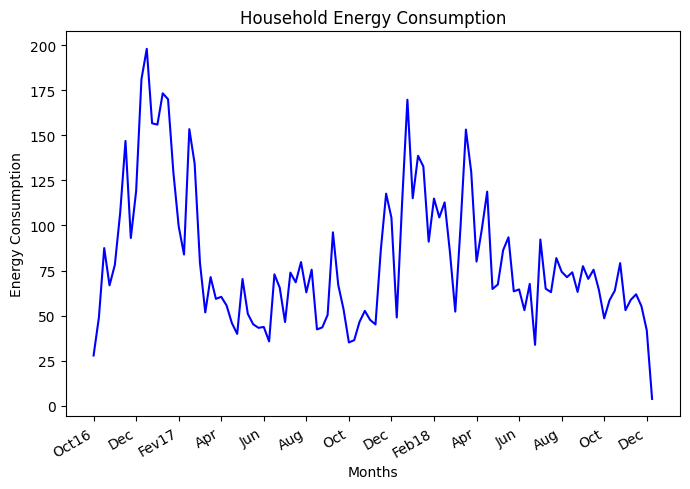

In [9]:
# let's plot the data set for a quick visualization

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(energy['usage'], 'b-')
ax.set_xlabel('Months')
ax.set_ylabel('Energy Consumption')

ax.set_xticks(np.arange(0, 105, 8), ['Oct16', 'Dec', 'Fev17', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec', 'Feb18', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec'])
ax.set_title('Household Energy Consumption')

fig.autofmt_xdate()
plt.tight_layout()


## Stationarity

In [10]:
AD_test_result = adfuller(energy['usage'])

print(f'AD_statistic:{AD_test_result[0]}')
print(f'p-value:{AD_test_result[1]}')

AD_statistic:-1.7037619216789146
p-value:0.42917527141570533


In [11]:
# let's perform a transformation
energy_diff = np.diff(energy['usage'], n=1)

AD_test_result = adfuller(energy_diff)

print(f'AD_statistic:{AD_test_result[0]}')
print(f'p-value:{AD_test_result[1]}')

AD_statistic:-8.888104130283766
p-value:1.2640026239834456e-14


the series is now stationary

## Train/Test slipt

In [12]:
train = energy['usage'][:-21]
test = energy.iloc[-21:]

print(f'length of the train set is:{len(train)}')
print(f'length of the test set is:{len(test)}')

length of the train set is:85
length of the test set is:21


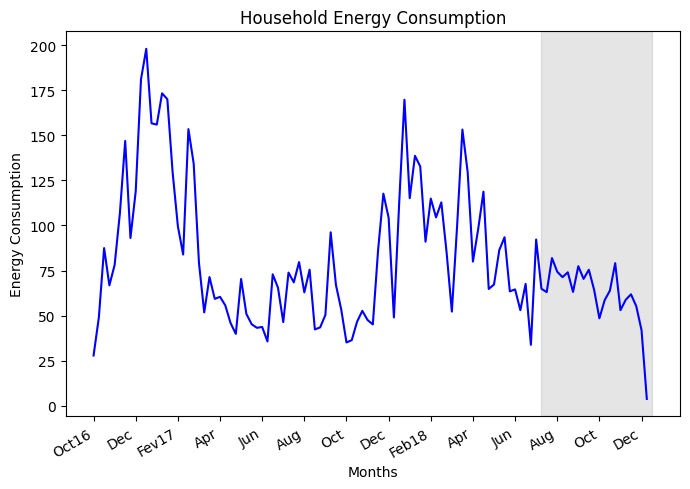

In [13]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(energy['usage'], 'b-')
ax.set_xlabel('Months')
ax.set_ylabel('Energy Consumption')
ax.axvspan(85, 106, color='#808080', alpha=0.2)

ax.set_xticks(np.arange(0, 105, 8), ['Oct16', 'Dec', 'Fev17', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec', 'Feb18', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec'])
ax.set_title('Household Energy Consumption')

fig.autofmt_xdate()
plt.tight_layout()

## Model Selection

In [14]:
def ARIMA_gridsearch(endog, min_p, max_p, min_q, max_q, d):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    
    all_orders = list(product(all_p, all_q))
    
    print(f'Fitting {len(all_orders)} unique models')
    
    results = []
    
    for order in tqdm_notebook(all_orders):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1])).fit()
        except:
            continue
            
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [15]:
result_df = ARIMA_gridsearch(train, 0, 4, 0, 4, 1)
result_df.head()

Fitting 25 unique models


  0%|          | 0/25 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(0, 4)",794.836911
1,"(3, 1)",794.988378
2,"(2, 0)",795.847334
3,"(3, 0)",795.925389
4,"(4, 0)",795.933153


In [16]:
# let's give a summary of the model

model = SARIMAX(train, order=(0,1,4), simple_differencing = False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  usage   No. Observations:                   85
Model:               SARIMAX(0, 1, 4)   Log Likelihood                -392.418
Date:                Thu, 16 Jan 2025   AIC                            794.837
Time:                        20:38:23   BIC                            806.991
Sample:                             0   HQIC                           799.723
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2247      0.094     -2.386      0.017      -0.409      -0.040
ma.L2         -0.3866      0.109     -3.562      0.000      -0.599      -0.174
ma.L3          0.0855      0.107      0.801      0.4

## Residuals Analysis

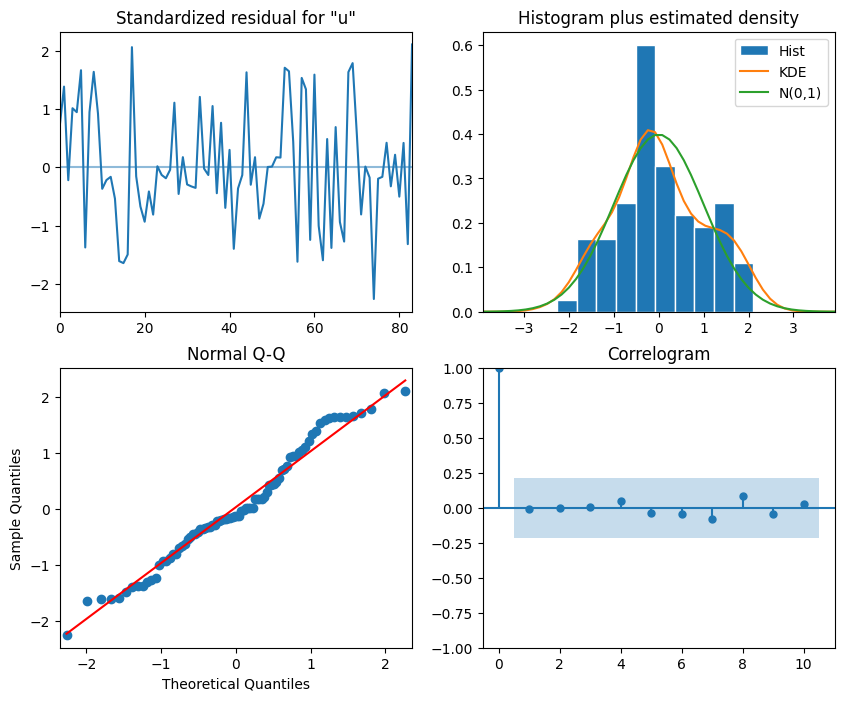

In [17]:
model_fit.plot_diagnostics(figsize=(10,8));

<p> The residuals are nearly straight on the Q-Q plot. In addition, the first plot shows no trend. 
The histogram suggests that the residuals are normally distributed and the correlogram shows no autocorrelation left; 
therefore, the residuals look like white noise. </p>

In [18]:
# Perform the Ljung-Box test
# Set return_df=False for array-like output (default in newer versions)
residuals = model_fit.resid

lb_test = acorr_ljungbox(residuals, lags=np.arange(1, 11, 1), return_df=True)

# Extract the p-values
pvalues = lb_test['lb_pvalue']

# Print the p-values
print("P-values for Ljung-Box test:", pvalues)

P-values for Ljung-Box test: 1     0.979966
2     0.981074
3     0.997862
4     0.977564
5     0.991308
6     0.996765
7     0.987207
8     0.969581
9     0.984029
10    0.991132
Name: lb_pvalue, dtype: float64


<p> the p values are all above 0.05, Therefore, at each lag, the
null hypothesis cannot be rejected, meaning that the residuals are independently distributed
and uncorrelated.</p>

## Forecasting

In [19]:
def rolling_predictions(df, train_len, horizon, window, method):
    
    TOTAL_LEN = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, TOTAL_LEN, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean[:horizon]

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value[:horizon]
    
    if method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df[:i], order=(4,1,4))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA[:horizon]

In [28]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)

windows = [8, 12]

for window in windows:

    pred_mean = rolling_predictions(energy[['usage']], TRAIN_LEN, HORIZON, window, 'mean')
    pred_last = rolling_predictions(energy[['usage']], TRAIN_LEN, HORIZON, window, 'last')
    pred_ARIMA = rolling_predictions(energy[['usage']], TRAIN_LEN, HORIZON, window, 'ARIMA')

    pred_df[f'pred_mean_{window}'] = pred_mean
    pred_df[f'pred_last_{window}'] = pred_last
    pred_df[f'pred_ARIMA_{window}'] = pred_ARIMA

pred_df.head()

,Date,usage,pred_mean_8,pred_last_8,pred_ARIMA_8,pred_mean_12,pred_last_12,pred_ARIMA_12
85,2018-06-04/2018-06-10,64.88,85.603765,92.2,86.305321,85.603765,92.2,86.305321
86,2018-06-11/2018-06-17,63.00,85.603765,92.2,65.587740,85.603765,92.2,65.587740
87,2018-06-18/2018-06-24,81.92,85.603765,92.2,63.568193,85.603765,92.2,63.568193
88,2018-06-25/2018-07-01,74.32,85.603765,92.2,81.015330,85.603765,92.2,81.015330
89,2018-07-02/2018-07-08,71.32,85.603765,92.2,81.568936,85.603765,92.2,81.568936


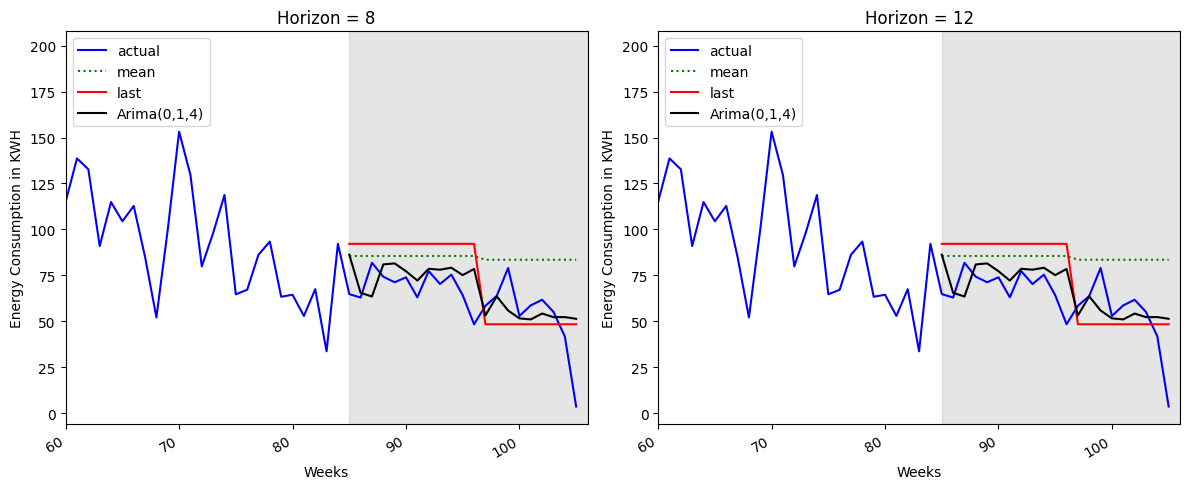

In [29]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 5))
for i, ax in enumerate(axes.flatten()):
    ax.plot(energy['usage'], 'b-', label = 'actual')
    ax.plot(pred_df[f'pred_mean_{window}'], 'g:', label = 'mean')
    ax.plot(pred_df[f'pred_last_{window}'], 'r-', label = 'last')
    ax.plot(pred_df[f'pred_ARIMA_{window}'], 'k-', label = 'Arima(0,1,4)')

    ax.legend(loc='best')
    ax.set_xlabel('Weeks')
    ax.set_ylabel('Energy Consumption in KWH')
    ax.axvspan(85, 106, color='#808080', alpha=0.2)
    ax.set_xlim(60, 106)
    ax.set_title(f'Horizon = {windows[i]}')

fig.autofmt_xdate()
plt.tight_layout()

## Model Evaluation

In [32]:
from sklearn.metrics import mean_absolute_error

mean_mae_8 = mean_absolute_error(pred_df['usage'], pred_df['pred_mean_8'])
last_mae_8 = mean_absolute_error(pred_df['usage'], pred_df['pred_last_8'])
arima_mae_8 = mean_absolute_error(pred_df['usage'], pred_df['pred_ARIMA_8'])

mean_mae_12 = mean_absolute_error(pred_df['usage'], pred_df['pred_mean_12'])
last_mae_12 = mean_absolute_error(pred_df['usage'], pred_df['pred_last_12'])
arima_mae_12 = mean_absolute_error(pred_df['usage'], pred_df['pred_ARIMA_12'])

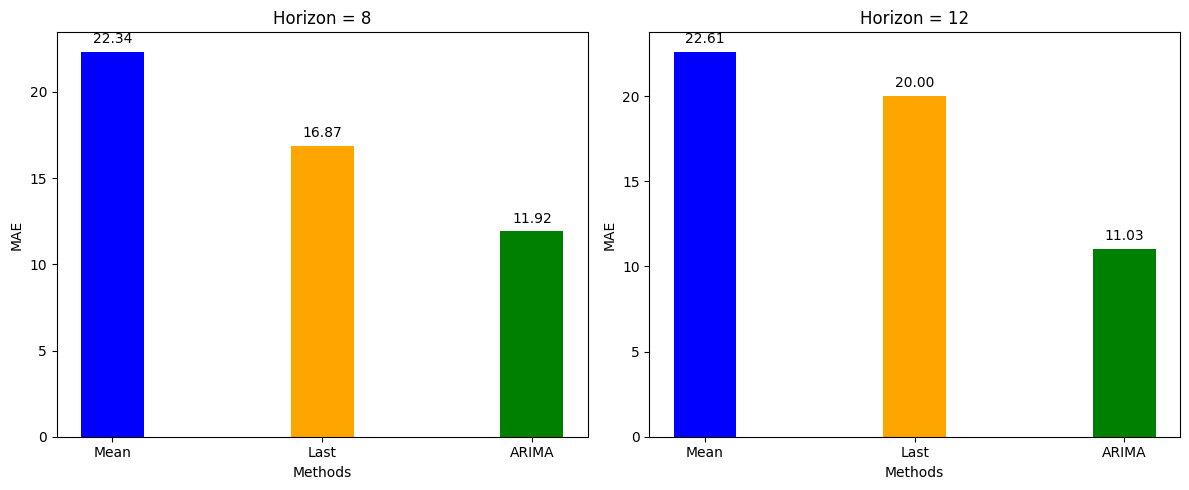

In [35]:
# MAPE results
mape_mean = [mean_mae_8, mean_mae_12]  # MAPE for mean method for windows 8 and 12
mape_last = [last_mae_8, last_mae_12]  # MAPE for last method for windows 8 and 12
mape_arima = [arima_mae_8, arima_mae_12] # MAPE for ARIMA method for windows 8 and 12

# Plot settings
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
methods = ['Mean', 'Last', 'ARIMA']
width = 0.3
windows = [8, 12]

# Loop to plot each subplot
for i, ax in enumerate(axes.flatten()):
    y = [mape_mean[i], mape_last[i], mape_arima[i]]
    ax.bar(methods, y, width, color=['blue', 'orange', 'green'])
    ax.set_xlabel('Methods')
    ax.set_ylabel('MAE')
    ax.set_title(f'Horizon = {windows[i]}')
    
    # Annotate the bars with values
    for index, value in enumerate(y):
        ax.text(index, value + 0.5, f'{value:.2f}', ha='center')

# Adjust layout
plt.tight_layout()
plt.show()